In [69]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.mixture import GaussianMixture

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import probplot, t, jarque_bera, normaltest, kstest, norm
import statsmodels.api as sm
from nova.clients.clients import clients

# Financial Basics


### Where do we get financial data ? (quandl, quantopian, AlphaVantage)

* For our case, we will get the information from Crypto Exchange APIs.

### What Financial data look like ?

* Open, High, Low, Close, Volume
* Order Book 
* Partially-Filled vs Filled
* Adjusted Closed

### Stock returns
* important to understand distributions
* normal distribution
* hypothesis testing
* skewness, kurtosis, correlation, covariance

### Gaussian Mixtures to model Stock Return

### Volatility Clustering

### Price Simulation (Monte Carlo)

## 1- What Financial data look like ?

In [2]:
binance_client = clients(
        exchange='binance',
        key="ZKn7kXCJN8StFACpyMO28QLvrb0s1xGYRcoaA1odXth6B9iy0SkJZ09Q5MwsKrXW",
        secret=f"JRTBODVexnCmZpkIkbnVbLtghDJIZef9iSTeoj2kriufholOUCgHHIFc5m3fxoQS",
)

In [3]:
# Download Data 
df = binance_client.get_historical_data(
    pair='BTCUSDT',
    interval='1h',
    start_ts= int(datetime(2019, 1, 1).timestamp() * 1000),
    end_ts= int(datetime(2022, 10, 1).timestamp() * 1000),
)

df.head()

In [4]:
# Get basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26843 entries, 0 to 26842
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   open_time           26843 non-null  int64  
 1   open                26843 non-null  float32
 2   high                26843 non-null  float32
 3   low                 26843 non-null  float32
 4   close               26843 non-null  float32
 5   volume              26843 non-null  float32
 6   close_time          26843 non-null  int64  
 7   quote_asset_volume  26843 non-null  float32
 8   nb_of_trades        26843 non-null  float32
 9   taker_base_volume   26843 non-null  float32
 10  taker_quote_volume  26843 non-null  float32
 11  ignore              26843 non-null  object 
 12  next_open           26843 non-null  float32
dtypes: float32(10), int64(2), object(1)
memory usage: 1.8+ MB


<AxesSubplot:>

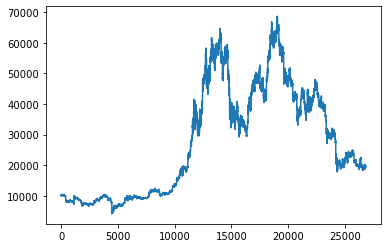

In [5]:
# Small plot of the time series
df['close'].plot()

In [6]:
# Starting and Ending Dates
datetime.fromtimestamp(df['open_time'].min()//1000), datetime.fromtimestamp(df['open_time'].max()//1000)

(datetime.datetime(2019, 9, 8, 13, 0), datetime.datetime(2022, 9, 30, 23, 0))

In [7]:
# Best solution for missing data is FORWARD and BACKWARD FILLING

In [8]:
# Net Returns
buy_hold_net_return = (df.loc[len(df)-1, 'close'] - df.loc[0, 'close']) / df.loc[0, 'close']

# Gross Return
buy_hold_gross_return = df.loc[len(df)-1, 'close'] / df.loc[0, 'close']

# Log Return
buy_hold_log_return = np.log(buy_hold_gross_return)
                                                       
buy_hold_net_return, buy_hold_gross_return, buy_hold_log_return

(0.9408, 1.9408, 0.66310024)

In [9]:
# adjusted Close takes into account stock splits and dividends

In [10]:
# Compute Return
df['previous_close'] = df['close'].shift(1)

df['net_return'] = (df['close'] - df['previous_close']) / df['previous_close']
df['gross_return'] = df['close'] / df['previous_close'] 
df['log_return'] = np.log(df['gross_return'])
df

,open_time,open,high,low,close,volume,close_time,quote_asset_volume,nb_of_trades,taker_base_volume,taker_quote_volume,ignore,next_open,previous_close,net_return,gross_return,log_return
0,1567962000000,10000.000000,10000.000000,10000.000000,10000.000000,0.002000,1567965599999,20.0,2.0,0.001000,1.000000e+01,0,10000.000000,NaN,NaN,NaN,NaN
1,1567965600000,10000.000000,10000.000000,10000.000000,10000.000000,0.000000,1567969199999,0.0,0.0,0.000000,0.000000e+00,0,10344.769531,10000.000000,0.000000,1.000000,0.000000
2,1567969200000,10344.769531,10357.530273,10337.429688,10340.120117,471.658997,1567972799999,4879792.5,562.0,0.000000,0.000000e+00,0,10340.120117,10000.000000,0.034012,1.034012,0.033446
3,1567972800000,10340.120117,10368.639648,10334.540039,10351.419922,583.270996,1567976399999,6037732.5,731.0,0.034000,3.519712e+02,0,10351.419922,10340.120117,0.001093,1.001093,0.001092
4,1567976400000,10351.419922,10391.900391,10324.769531,10391.900391,689.758972,1567979999999,7136798.5,827.0,0.004000,4.138500e+01,0,10392.589844,10351.419922,0.003911,1.003911,0.003903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26838,1664578800000,19378.000000,19461.300781,19351.099609,19411.699219,17905.986328,1664582399999,347656384.0,113990.0,8940.044922,1.735826e+08,0,19411.599609,19378.000000,0.001739,1.001739,0.001738
26839,1664582400000,19411.599609,19474.000000,19338.000000,19393.099609,18441.044922,1664585999999,357797248.0,114737.0,8512.752930,1.652034e+08,0,19393.099609,19411.699219,-0.000958,0.999042,-0.000959
26840,1664586000000,19393.099609,19424.099609,19361.300781,19413.199219,8934.250977,1664589599999,173220240.0,65729.0,4780.470215,9.268706e+07,0,19413.199219,19393.099609,0.001036,1.001036,0.001036
26841,1664589600000,19413.199219,19427.900391,19376.599609,19405.099609,6643.362793,1664593199999,128909888.0,52144.0,3277.762939,6.360273e+07,0,19405.099609,19413.199219,-0.000417,0.999583,-0.000417


<AxesSubplot:>

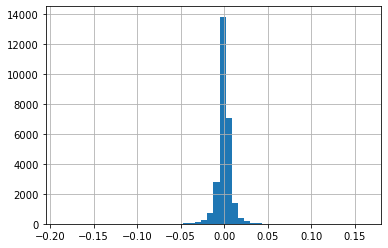

In [11]:
# Distribution of Return
df['net_return'].hist(bins=50)

((array([-4.04806017, -3.83540636, -3.71918937, ...,  3.71918937,
          3.83540636,  4.04806017]),
  array([-0.18709065, -0.17811044, -0.10574818, ...,  0.13890201,
          0.16270693,         nan], dtype=float32)),
 (nan, nan, nan))

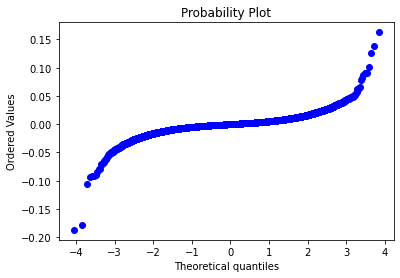

In [12]:
# QQ-plot (quantile-quantile plot)

# If you are seeing a straight line, it means that the data really come from the distribution assumed
# QQ plots deviate with heavy tails in the distributions


probplot(df['net_return'], dist='norm', fit=True, plot=plt)

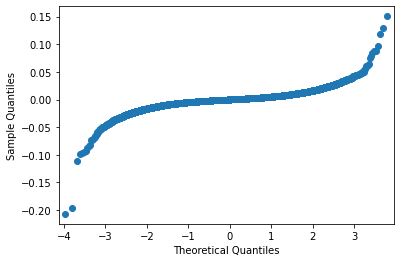

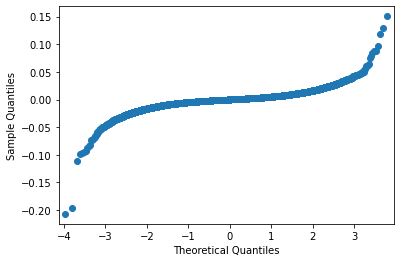

In [13]:
sm.qqplot(df['log_return'], line='s')

In [14]:
# In general the normal distribution is not a good fit to model returns in finance => try with t-distribution
degree_freedom, location, scale = t.fit(df['net_return'].dropna())

In [15]:
pred = t.pdf(df['net_return'].dropna(), degree_freedom, location, scale)

<AxesSubplot:>

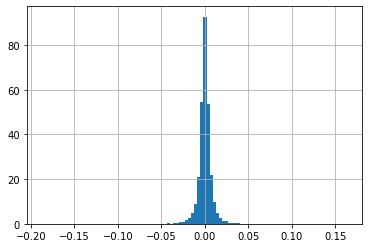

In [16]:
df['net_return'].dropna().hist(bins=100, density=True)

In [17]:
class t_dist:
    def __init__(self, degree_freedom):
        self.df = degree_freedom
    def fit(self, x):
        return t.fit(x)
    def ppf(self, x, loc=0, scale=1):
        return t.ppf(x, self.df, loc, scale)

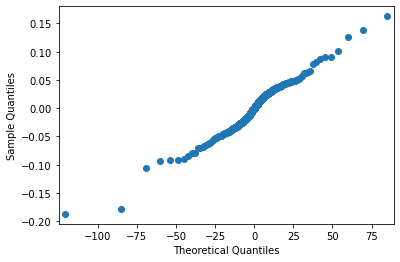

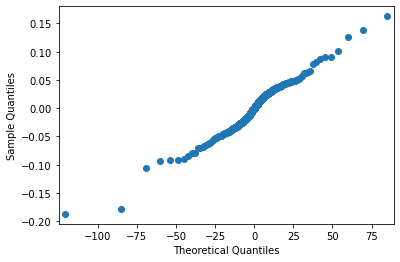

In [18]:
sm.qqplot(df['net_return'], dist=t_dist(degree_freedom), line='s')

In [19]:
# Mean / Variance are 2 ways to characterize a distribution (respectively First and Second moment of distribution)
# Skewness and Kurtosis (Third and Fourth moment of distribution)

# Skewness is an Asymmetry measure (left skewed if Skewness < 0 else right skewed)
# Kurtosis measure the heavyness of the tails looking at the "Excess Kurtosis" == Kurtosis - 3 (N-dist Kurosis = 3)

skweness = df['net_return'].skew()
kurtosis = df['net_return'].kurtosis()


if skweness < 0:
    print('You are more likely to get extrem negative values')
else :
     print('You are more likely to get extrem positive values')
        

skweness, kurtosis

You are more likely to get extrem negative values


(-0.4857836, 44.84594)

In [20]:
# Confidence Interval Using T-Distribution and Normal-Distribution
# Can also use Bootstrapping

In [21]:
# Statistical Testing jarque_bera
jarque_bera(df['net_return'].dropna())

Jarque_beraResult(statistic=2249507.1560070305, pvalue=0.0)

In [22]:
# Statistical Testing normaltest
normaltest(df['net_return'].dropna())

NormaltestResult(statistic=9574.320842551422, pvalue=0.0)

In [23]:
# Statistical Testing cdf
degree, location, scale = t.fit(df['net_return'].dropna())

def cdf(x):
    return t.cdf(x, degree, location, scale)

kstest(df['net_return'].dropna(), cdf)

KstestResult(statistic=0.010131523345505267, pvalue=0.00803273609701034)

In [24]:
# Coveriance / Correlation / Covariance Matrix

eth = binance_client.get_historical_data(
    pair='ETHUSDT',
    interval='1h',
    start_ts= int(datetime(2019, 1, 1).timestamp() * 1000),
    end_ts= int(datetime(2022, 10, 1).timestamp() * 1000),
)

xrp = binance_client.get_historical_data(
    pair='XRPUSDT',
    interval='1h',
    start_ts= int(datetime(2019, 1, 1).timestamp() * 1000),
    end_ts= int(datetime(2022, 10, 1).timestamp() * 1000),
)

eth.shape, xrp.shape

((24933, 13), (23972, 13))

In [28]:
# build the return for each 
for name, x in {'eth':eth , 'xrp': xrp}.items():
    x['previous_close'] = x['close'].shift(1)
    x [f'net_return_{name}'] = (x ['close'] - x ['previous_close']) / x ['previous_close']
    x ['gross_return'] = x ['close'] / x ['previous_close'] 
    x ['log_return'] = np.log(x ['gross_return'])
    
eth.shape, xrp.shape

((24933, 17), (23972, 17))

In [32]:
return_df = df[['open_time', 'net_return']]
return_df.columns = ['open_time', 'net_return_btc']


return_df = pd.merge(return_df, eth[['open_time', 'net_return_eth']], on=["open_time"])
return_df = pd.merge(return_df, xrp[['open_time', 'net_return_xrp']], on=["open_time"])

return_df.dropna(inplace=True)
return_df.set_index('open_time', inplace=True)

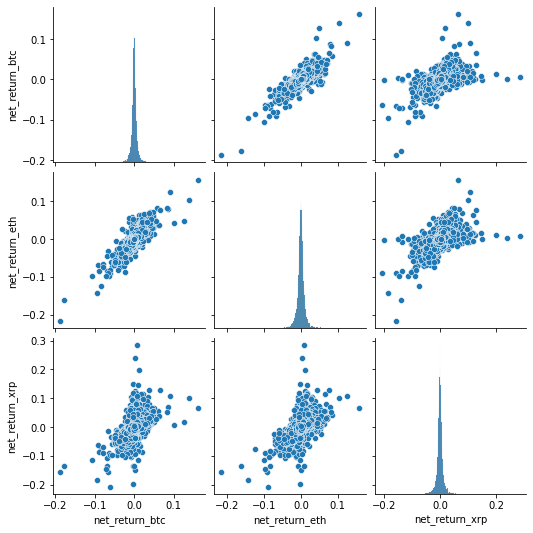

In [35]:
sns.pairplot(return_df)

In [36]:
# mean returns
return_df.mean()

net_return_btc    0.000074
net_return_eth    0.000150
net_return_xrp    0.000127
dtype: float32

In [37]:
# standard deviation returns 
return_df.std()

net_return_btc    0.008308
net_return_eth    0.010577
net_return_xrp    0.013505
dtype: float32

Text(0, 0.5, 'Return')

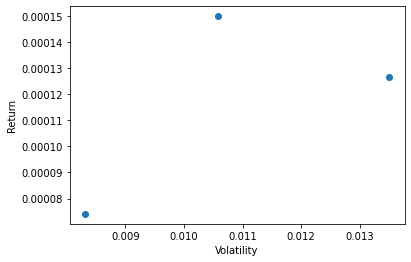

In [38]:
# plots 
plt.scatter(return_df.std(), return_df.mean())
plt.xlabel('Volatility')
plt.ylabel('Return')

In [40]:
# Correlation Matrix
return_df.corr()

,net_return_btc,net_return_eth,net_return_xrp
net_return_btc,1.000000,0.848449,0.613385
net_return_eth,0.848449,1.000000,0.640782
net_return_xrp,0.613385,0.640782,1.000000


In [41]:
# Covariance Matrix
return_df.cov()

,net_return_btc,net_return_eth,net_return_xrp
net_return_btc,0.000069,0.000075,0.000069
net_return_eth,0.000075,0.000112,0.000092
net_return_xrp,0.000069,0.000092,0.000182


<AxesSubplot:xlabel='open_time'>

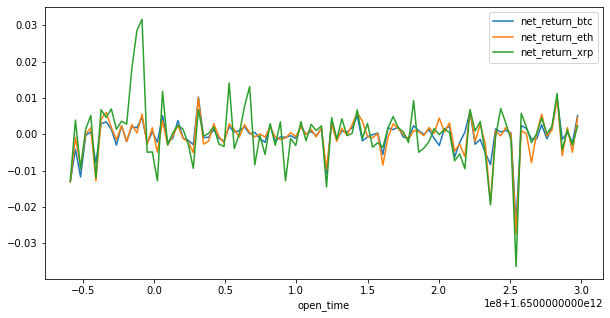

In [51]:
# plot 

return_df.iloc[19900: 20000].plot(figsize=(10,5))

In [55]:
# Alpha and Beta
reg_model = LinearRegression()

X = return_df[['net_return_eth']]
y = return_df[['net_return_btc']]
reg_model.fit(X, y)

LinearRegression()

/Users/ariisichoix/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


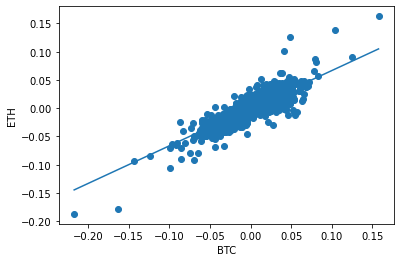

In [58]:
X_predict = np.linspace(X.min(), X.max(), 5).reshape(-1,1)
y_predict = reg_model.predict(X_predict)


plt.scatter(X,y);
plt.xlabel("BTC");
plt.ylabel("ETH");
plt.plot(X_predict, y_predict)


In [60]:
beta = reg_model.coef_
alpha = reg_model.intercept_

alpha, beta

(array([-2.5890906e-05], dtype=float32), array([[0.66642463]], dtype=float32))

In [67]:
# Gaussian Mixture Model (GMM) -> Try to model the data

data = return_df[['net_return_btc']]

mixture_model = GaussianMixture(n_components=2)
mixture_model.fit(data)


weights = mixture_model.weights_
means = mixture_model.means_
cov = mixture_model.covariances_

print(f'weights : {weights}')
print(f'means : {means}')
print(f'covariances : {cov}')

weights : [0.77836939 0.22163061]
means : [[ 1.09667337e-04]
 [-5.08823544e-05]]
covariances : [[[1.79910230e-05]]

 [[2.52709265e-04]]]


In [66]:
means = means.flatten()
var = cov.flatten()

In [70]:
x_list = np.linspace(data.min(), data.max(), 100)
fx0 = norm.pdf(x_list, means[0], np.sqrt(var[0]))
fx1 = norm.pdf(x_list, means[1], np.sqrt(var[1]))
fx = weights[0] * fx0 + weights[1] * fx1

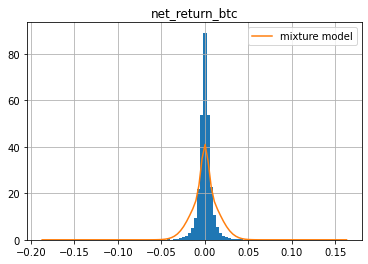

In [71]:
data.hist(bins=100, density=True)
plt.plot(x_list, fx, label='mixture model');
plt.legend();

In [72]:
# Volatility Clustering => it's just the observation that high volatility episodes are usually clustered next to each other

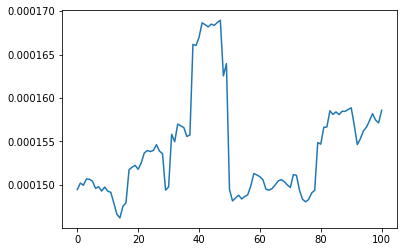

In [76]:
# Simulating Stock Prices

p0 = return_df.iloc[-1]['net_return_btc']
prices = [p0]

# use a fitted T distribution and selecting a random return within this distribution
degree_freedom, locations, scale = t.fit(return_df['net_return_btc'])

for _ in range(100):
    r = t.rvs(degree_freedom, locations, scale)
    p = prices[-1] *(1 + r)
    prices.append(p)
    
plt.plot(prices)